# Grado en ciencia de datos - Big Data

# Práctica 3.2- Regresión

Vamos a ver un problema de regresión con la librería de Spark MLib.

Ten en cuenta que una vez tengas en marcha Spark, podrás visualizar la evolución de cada trabajo de Spark en  <http://localhost:4040>

## Análisis de un dataset sobre alquiler de bicicletas

En esta práctica vamos a ver cómo usar las Pipelines de ML para entrenar un modelo que sea capaz de predecir valores reales (regresión).

**Sobre los datos**: El problema que vamos a afrontar consiste en la predicción del número de bicis que van a ser alquiladas. Para ello, usaremos un dataset con información de los años 2011 y 2012 del sistema Capital usado en la ciudad de Oporto (Portugal). Además tendremos información adicional sobre las condiciones metereológicas. El dataset está disponible en la [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

**Objetivo**: Queremos predecir cuántas bicis serán alquiladas cada hora en base a la información sobre el día de la semana, el tiempo, la temporada, etc. Lograr buenas predicciones de la demanda permitiría al negocio estar preparado para atender incrementos en la demanda cuando sea necesario, por ejempo.

**Aproximación**: Utilizaremos las Pipelines de SparkML. Llevaremos a cabo también la optimización de los parámetros del modelo mediante validación cruzada para mejorar la predicción final.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Ejemplo pySparkSQL") \
    .config("spark.sql.warehouse.dir", "file:///D:/tmp/spark-warehouse") \
    .getOrCreate()

sc = spark.sparkContext

25/12/19 15:59:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Otros imports necesarios:

In [3]:
%matplotlib inline 
from pyspark.sql import Row
from test_helper import Test
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

## Carga y análisis de los datos

Comenzamos cargando los datos que están en formato CSV. Los cargamos en un DataFrame y lo cacheamos

In [5]:
# Utilizar spark.read para leer el fichero con las siguientes opciones
#  'format': especificar 'csv'
#  'header': establecer a true para indicar que la primera línea es el header
# El fichero se llama 'hour.csv'.

df = spark.read.format('csv').option('header', 'true').load('/Users/vergara/Documents/Master/Computación Avanzada/Practicas_BigData/P3/datos/Bike-Sharing-Dataset/hour.csv')

# Cachear el DataFrame ¡¡¡CUIDADO LABORATORIO VIRTUAL!!!
df.cache()

DataFrame[instant: string, dteday: string, season: string, yr: string, mnth: string, hr: string, holiday: string, weekday: string, workingday: string, weathersit: string, temp: string, atemp: string, hum: string, windspeed: string, casual: string, registered: string, cnt: string]

In [6]:
Test.assertEquals(df.is_cached, True, 'df no cacheado')#Depende de que día tenga el laboratorio virtual...
Test.assertEquals(df.count(), 17379, 'Número de filas en df incorrectas')

1 test passed.
1 test passed.


#### Descripción de los datos

Siguiendo la información del repositorio [UCI](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), conocemos el significado de cada una de las columnas.

**Columnas que son cracterísticas**:
* dteday: fecha
* season: estación (1:primavera, 2:verano, 3:otoño, 4:invierno)
* yr: año (0:2011, 1:2012)
* mnth: mes (1 to 12)
* hr: hora (0 to 23)
* holiday: si es día festivo o no
* weekday: día de la semana
* workingday: si el día no es ni fin de semana ni festivo entonces es 1, sino 0
* weathersit: 
  * 1: Sin nubes, pocas nubes, alguna nube
  * 2: Niebla + nubes, Niebla + algunas nubes
  * 3: Poca nieve, algo de agua, truenos
  * 4: Mucha lluvia, nieve
* temp: Temperatura normalizada en grados celsius. El valor derivado de `(t-t_min)/(t_max-t_min)`, `t_min=-8`, `t_max=+39` (cada hora)
* atemp: Sensación de temperatura normalizada en grados celsius. El valor derivado de `(t-t_min)/(t_max-t_min)`, `t_min=-16`, `t_max=+50` (cada hora)
* hum: Humedad normalizada. El valor se divide por 100 (max)
* windspeed: Velocidad del viento normalizada. El valor se divide por 67 (max)

**Columnas que son etiquetas**:
* casual: conteo de usuarios tipo casual
* registered: conteo de usuarios registrados
* cnt: conteo total de alquileres incluyendo casuals y registrados

**Columnas extra**:
* instant: índice del registro

Por ejemplo, la primera fila es un registro con hora 0 el 1 de enero de 2011 -- y aparentemente 16 personas cogieron una bici a medianoche!

Vamos a usar show para ver qué tipo de datos tenemos.

In [7]:
# Muestra algunas filas y el esquema para ver los tipos
df.show(5)
df.printSchema()

+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|    dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|        0|     3|        13| 16|
|      2|2011-01-01|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     8|        32| 40|
|      3|2011-01-01|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     5|        27| 32|
|      4|2011-01-01|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|        0|     3|        10| 13|
|      5|2011-01-01|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|        0

El dataset está perfectamente preparado para usar ML: los días de la semana están indexados, todas las columnas excepto `dteday` son numéricas

In [8]:
# Calcula cuántas filas tiene el DataFrame
print("El dataset tiene %d filas." % df.count())

El dataset tiene 17379 filas.


## Preprocesamiento de los datos

Vamos a realizar los pasos necesarios para montar el dataset de tal forma que podamos usarlo para aplicar los algoritmos de machine learning.

*Objetivo*: Queremos predecir el número de bicis alquiladas (columna `cnt`). Esta será pues nuestra columna con las etiquetas.

*Características*: ¿Qué podemos usar como atributos para describir cada fila y predecir `cnt`? Podemos usar el resto de las columnas con algunas excepciones:
* Algunas contienen información duplicada. Por ejemplo, `cnt` es la suma de `casual` y `registered`. Eliminaremos estas dos columnas para estar seguros de que no las usamos para predecir `cnt`. **Esto es un problemas importante en ML, estar seguros de que no hacemos trampas usando información que no tenemos para hacer las predicciones**.
* Columna `dteday`: Podríamos mantenerla pero está ya bien representada por otras columnas relacionadas `season`, `yr`, `mnth`, y `weekday`.  La eliminaremos.
* Columna `instant`: Esta columna no es útil para la predicción.


In [9]:
# Aplicar las transformaciones necesarias para eliminar las columnas instant, dteday, casual y registered (usar drop)
df = df.drop('instant', 'dteday', 'casual', 'registered')
df.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|        0| 16|
|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|        0| 40|
|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|        0| 32|
|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|        0| 13|
|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|        0|  1|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
only showing top 5 rows



In [10]:
Test.assertEquals("instant" in df.columns, False, "Columna instant no eliminada")
Test.assertEquals("dteday" in df.columns, False, "Columna dteday no eliminada")
Test.assertEquals("casual" in df.columns, False, "Columna casual no eliminada")
Test.assertEquals("registered" in df.columns, False, "Columna registered no eliminada")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


Ahora ya solo tenemos las columnas que nos interesan. Veamos el esquema con el tipo de columnas que tenemos.

In [11]:
# Imprime el esquema del DataFrame df
df.printSchema()

root
 |-- season: string (nullable = true)
 |-- yr: string (nullable = true)
 |-- mnth: string (nullable = true)
 |-- hr: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- workingday: string (nullable = true)
 |-- weathersit: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- atemp: string (nullable = true)
 |-- hum: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- cnt: string (nullable = true)



En el DataFrame todo son strings!! Pero sabemos que las columnas son realmente numéricas, vamos a pasarlas a números... Esto ha ocurrido porque hemos leídos los datos como un csv.

In [12]:
# Esta celda coge todas las columnas (df.columns) y hace un cast usando Spark SQL a numérico (DoubleType).
from pyspark.sql.functions import col  # para indicar una columna usando un string
df = df.select([col(c).cast("double").alias(c) for c in df.columns])
df.printSchema()

root
 |-- season: double (nullable = true)
 |-- yr: double (nullable = true)
 |-- mnth: double (nullable = true)
 |-- hr: double (nullable = true)
 |-- holiday: double (nullable = true)
 |-- weekday: double (nullable = true)
 |-- workingday: double (nullable = true)
 |-- weathersit: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: double (nullable = true)



#### Dividir los datos en training y test

Para poder estudiar la validez del modeo creado, vamos a dividir el dataset en dos conjuntos de entrenamiento: train y test. Podemos entrenar y ajustar el modelo usando el training siempre que no usemos el test. Posteriormente, usaremos el conjunto de test para validar el modelo final y ver lo bueno que es para predecir observaciones futuras.

In [13]:
# Dividir el dataset en el 70% para train y el 30% para test
# Utilizar la transformación randomSplit con la semilla seed
seed = 1203123
train, test = df.randomSplit([0.7, 0.3], seed)
print("Tenemos %d ejemplos en training y %d en test." % (train.count(), test.count()))

Tenemos 12246 ejemplos en training y 5133 en test.


In [14]:
Test.assertEquals(train.count(), 12246, 'Número de ejemplos en train incorrectos')
Test.assertEquals(test.count(), 5133, 'Número de ejemplos en test incorrectos')

1 test passed.
1 test passed.


#### Visualización de los datos

Ahora que hemos preprocesado las características y preparado nuestro conjunto de entrenamiento podemos visualizar los datos para ver si las características que tenemos son significativas.

Para ello vamos a realizar un plot con el número de alquileres que se realizan cada hora (sumamos los conteos que tenemos para cada hora). Veremos así si parece haber una relación entre la hora y el número de alquieleres o no.

In [15]:
# Obtén un DataFrame en el que para cada hora tengas la suma total de alquileres (agrupar por hora y sumar cnt)
# Aplica un collect para traer el DataFrame al driver. Antes del collect ordena el DataFrame por horas
hr_cnt = train.groupBy("hr").sum("cnt").orderBy("hr").collect()

# Dado que obtenemos una lista de filas, utiliza la siguiente línea para obtener una lista de tuplas (hora, conteo)
hr_cnt_tuples = list(map(lambda row: (row["hr"], row["sum(cnt)"]), hr_cnt))

In [16]:
Test.assertEquals(list(hr_cnt_tuples), [(0.0, 27907.0),(1.0, 16680.0), (2.0, 11789.0), (3.0, 5839.0), (4.0, 3191.0), (5.0, 10404.0),
                 (6.0, 39145.0), (7.0, 109040.0), (8.0, 183371.0), (9.0, 113635.0), (10.0, 93996.0), (11.0, 109581.0), (12.0, 123065.0),
                 (13.0, 134100.0), (14.0, 124033.0), (15.0, 131260.0), (16.0, 160588.0), (17.0, 235935.0), (18.0, 216456.0),
                 (19.0, 164256.0), (20.0, 117639.0), (21.0, 87664.0), (22.0, 69302.0), (23.0, 44605.0)], 
                 'hr_cnt incorrecto. Recuerda que debe estar ordenado por horas.')

1 test passed.


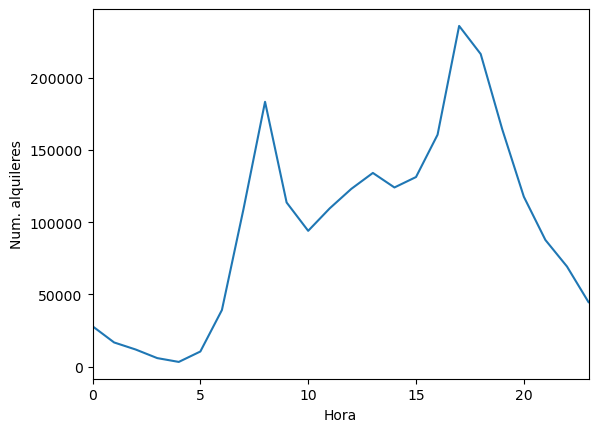

In [17]:
# Con el siguiente plot pintamos los datos obtenidos
plt.plot(list(zip(*hr_cnt_tuples))[0], list(zip(*hr_cnt_tuples))[1])
plt.ylabel('Num. alquileres')
plt.xlabel('Hora')
plt.xlim([0, 23])
plt.show()

En el plot podemos ver como el número de alquileres es bajo por la noche y que a las 8 de la mañana hay un pico y otro a alas 6 de la tarde. Esto indica que `hr`puede ser de utilidad para predecir el conteo `cnt`.

Si te apetece puedes intentar realizar otras visualizaciones para ver si las otras variables son de utilidad o no.

## Entrenamiento usando las Pipeline de Spark ML

En este caso, tenemos un problema de regresión donde la variable a estimar es `cnt` y el resto serán las características a utilizar (tiempo, día de la semana, etc.).

Vamos a crear una Pipeline simple con las siguientes fases:
* `VectorAssembler`: Unirá todas las columnas de características en una única columna con el vector de características. Necesario para los métodos de ML en Spark ML.
* `VectorIndexer`: Indetificará las columnas que deben ser tratadas como categóricas o nominales. Esto se realiza heurísticamente identificando las columnas con un número pequeño de valores diferentes. Para nosotros, estas serán `yr`(2 valoreS), `season` (4 valores), `holiday` (2 valores), `workingday` (2 valores) y `weathersit` (4 valores).
* `GBTRegressor`: En este caso vamos a usar un ensemble que se llama [Gradient-Boosted Trees (GBT)](https://en.wikipedia.org/wiki/Gradient_boosting). Podemos asumir que es similar a una regresión lineal pero con otros parámetros. Le damos un vector de entrada y nos devuelve un valor de salida.
* `CrossValidator`: El algoritmo GBT  tiene varios parámetros y ajustarlos suele tener un importante efecto en la precisión. Para el ajuste utilizaremos la validación cruzada disponible en Spark que automáticamente probará todo la malla de parámetros para elegir la mejor combinación.

Primero, definimos el procesamiento de las características para la Pipeline:
* Unimos las características en un vecto de características
* Identificamos las características categóricas y las indexamos

In [18]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
featuresCols = df.columns 
featuresCols.remove('cnt') 

# Lo siguiente concatena todas las columnas de características en un único vector de características en una nueva columna "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")

# Identificamos las características categóricas y las indexamos - serán categóricas aquellas que tengan 4 o menos valores distintos
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

Ahora definimos la fase para el entrenamiento del modelo. `GBTRegressor` toma un vector de características y las etiquetas como entradas y aprende un modelo de regresión que luego podremos utilizar para predecir nuevos ejemplos.

In [19]:
from pyspark.ml.regression import GBTRegressor
# Toma las columna "features" y aprende a predecir "cnt"
# Solo creamos el modelo, pero no lo entrenamos hasta usar fit()
gbt = GBTRegressor(labelCol="cnt")

A continuación, introduciremos el modelo en una fase de validación cruzada (`CrossValidator`). Esta clase sabe cómo debe llamar a GBT con los diferentes parámetros. Aprenderá varios modelos con diferentes parámetros y elegirá el mejor respecto a la medida establecida. Dado que estamos trabajando con un problema de regresión, utilizaremos la métrica [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation).


In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Definición del grid de parámetros para la búsqueda:
# - maxDepth: Es la máxima profundidad de los árboles en el ensemble GBT
# - maxIter: El el número de iteraciones, es decir, el número de árboles en cada ensemble
# Para que el tiempo de ejecución no sea demasiado alto, vamos a mantener estos valores bajos.
# En la realidad, para obtener la precisión máxima sería conveniente aumentar la profundidad de los árboles (> 10) 
# e introducir más árboles en cada ensemble (> 100)
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5])\
  .addGrid(gbt.maxIter, [10, 20])\
  .build()

# Definimos una métrica para la evaluación, que le dirá a CrossValidator cómo de bien lo está haciendo cada modelo
evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())

# Declaramos el CrossValidator, que requiere de un estimator, un evaluator y los estimatorParamMaps (parámetros)
# Consulta http://spark.apache.org/docs/2.4.5/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(
  estimator=gbt,
  estimatorParamMaps=paramGrid,
  evaluator=evaluator,
  numFolds=3
)

Finalmente podemos unir nuestra fase de procesamiento de características con el entrenamiento del modelo en una única `Pipeline`.

In [21]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])

#### Entrenamiento de la Pipeline

Ahora que ya tenemos el flujo de datos definido, podemos entrenar la Pipeline completa con una única llamada a `fit()`. Esta llamada llevará a cabo el preprocesamiento de características, el ajuste de los parámetros y el entrenamiento del modelo final.

Como resultado obtendremos una Pipeline ajustada (PipelineModel).

**NOTA**: La próxima celda puede tardar un rato (10 minutos). Esto es necesario porque se construyen muchos árboles:
* Para cada partición de la validación cruzada
    * Para cada conjunto de los parámetros
        * Se entrena un GBT con muchos árboles de decisión

In [22]:
# Entrenar la pipeline con fit y el conjunto de train
pipelineModel = pipeline.fit(train)

25/12/19 16:10:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/19 16:10:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


## Realizando predicciones y evaluando los resultados obtenidos

Una vez ajustados los parámetros y entrenado el modelo final, ya podemos realizar predicciones sobre datos nuevos. Utilizaremos para simularlos el conjunto de test, aunque podríamos usar datos completamente nuevos. Por ejemplo, si pudiéramos predecir las variables sobre el tiempo de la semana que viene, podríamos predecir los alquileres de bicis para la próxima semana.

Ya que nuestro conjunto de test tiene los datos etiquetados, lo utilizaremos para evaluar las predicciones, lo que nos permitirá comprender la calidad de las predicciones y compararlo con otros modelos o parámetros en el futuro.

Para obtener las predicciones sobre un DataFrame, utilizamos el método `transform()` que nos devuelve un nuevo DataFrame con una nueva columna llamada `predictions` así como los resultados intermedios como `rawFeatures` etc.

In [23]:
# Utiliza el método transform() para obtener las predicciones sobre el conjunto de test
predictions = pipelineModel.transform(test)

Es más fácil ver los resultados si limitamos las columnas:
* `cnt`: el número real de bicicletas alquiladas
* `prediction`: nuestra predicción sobre el número de bicicletas alquiladas
* columnas con las características: columnas con las características

In [24]:
# Utiliza un select seguido de un show para mostrar las primeras predicciones
# En el select queremos seleccionar las columnas cnt, prediction y las existentes en featuresCols. 
# Para incluir esta última como argumento utiliza un asterisco: *featuresCols
predictions.select('cnt', 'prediction', *featuresCols).show(5)

+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
| cnt|        prediction|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|
+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
|22.0| 34.20120955029297|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.04|0.0758|0.57|   0.1045|
|25.0| 34.20120955029297|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0| 0.1|0.0758|0.42|   0.3881|
|33.0|30.002667598115632|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.16|0.1818| 0.8|   0.1045|
| 5.0|  22.9504006015348|   1.0|0.0| 1.0|0.0|    0.0|    2.0|       1.0|       1.0|0.16|0.1818|0.55|   0.1045|
|17.0|  32.7307602883548|   1.0|0.0| 1.0|0.0|    0.0|    3.0|       1.0|       2.0|0.22|0.2273|0.69|   0.1343|
+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
o

¿Son los resultados suficientemente buenos? No son perfectos, pero parece que existe cierta correlación entre cnt y predictions y existe margen de mejora (ver última sección).

Antes de terminar, vamos a ver un par de formas más para comprender mejor los resultados.

**(1) Métricas**: Ver las predicciones manualmente no nos ayuda más que a tener una ligera idea de la precisión. Pero es mucho más útil tener una medida concreta. En la siguiente celda utilizaremos el evaluator creado anteriormente para obtener el RMSE en test (cuanto menor es el valor, mejor es el resultado). Aunque la métrica no dice mucho por si misma, nos permite comparar diferentes modelos.

In [25]:
# Utiliza el evaluator con su método evaluate para obtener el RMSE a partir del DataFrame predictions
rmse = evaluator.evaluate(predictions)
print("RMSE en test: %g" % rmse)

RMSE en test: 61.6969


RMSE approx. 61.24

**(2) Visualización**: Podemos pintar las predicciones vs. las características para comprender si están siendo usadas correctamente para la predicción, de manera similar a como hemos pintado antes las características vs. el conteo real. Siguiendo con ese ejemplo anterior, vamos a ver cómo es la predicción respecto a la hora del día.

*Nota: también se pueden realizar otros plots para comprar las predicciones vs. el conteo real.*

In [26]:
# Utiliza el DataFrame predictions y obtén para cada hora la suma de la columna "prediction", ordena el resultado por horas
# Finalmente utiliza collect() para traer el resultado al driver
hr_cnt = predictions.groupBy("hr").sum("prediction").orderBy("hr").collect()

# Pasamos las rows obtenidas a tuplas para pintarlas
hr_cnt_tuples_prediction = list(map(lambda row: (row["hr"], row["sum(prediction)"]), hr_cnt))

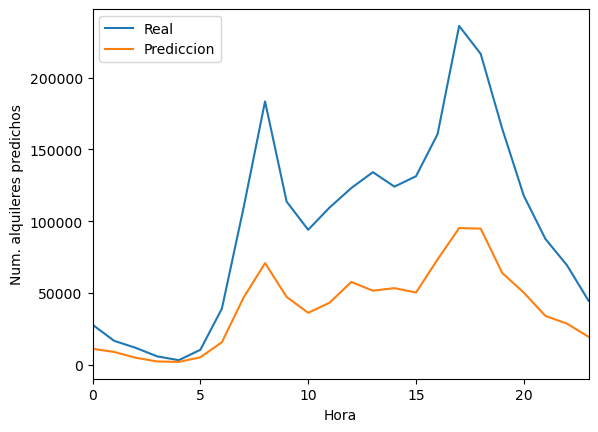

In [27]:
# Utilizamos la lista que acabamos de obtener junto con la que teníamos antes para mostrar
# un gráfico con el conteo real y el conteo predicho en base a las horas del día.
plt.plot(list(zip(*hr_cnt_tuples))[0], list(zip(*hr_cnt_tuples))[1])
plt.plot(list(zip(*hr_cnt_tuples_prediction))[0], list(zip(*hr_cnt_tuples_prediction))[1])
plt.ylabel('Num. alquileres predichos')
plt.xlabel('Hora')
plt.xlim([0, 23])
plt.legend(['Real', 'Prediccion'], loc=0)
plt.show()

Podemos observar como aunque la predicción no es muy acertada aparentemente, tenemos un comportamiento similar en ambas líneas, existiendo el mismo pico a las 8 de la mañana y a las 6 de la tarde. 

#### ¿Cómo mejoramos el modelo?

Hay diferentes formas de mejorar el modelo obtenido:
* **Conocimiento experto**: Puede que no seamos expertos en el alquiler de bicis, pero hay cosas que podemos aplicar:
  * El conteo de las bicis alquiladas no puede ser negativo.  `GBTRegressor` no lo sabe, pero podemos aplicar una umbralización a posteriori y poner todas las predicciones menores que 0 a 0.
  * El conteo de las bicis alquiladas es la suma de `registered` y `casual`. Estos dos conteos pueden tener un comportamiento muy diferente (los ciclistas frequentes y los casual alquilan bicis por diferentes razones). Los mejores modelos para este dataset tienen esto en cuenta. Puedes intentar crear un GBT para los usuarios registrados y otro para los casual y unir las predicciones para obtener la final.
* **Mejor ajuste de parámetros**: Para que el notebook no tardara mucho, solo hemos probado unos pocos parámetros para el modelo. Deberíamos probar más valores para obtener un resultado mejor. Puede probar incrementando el número de árboles del GBT, por ejemplo, `maxIter=200`; necesitará más tiempo para el entrenamiento pero puede ser más preciso.
* **Ingeniería de caractarerísticas / Feature engineering**: Hemos usado el conjunto básico de características, pero podríamos mejorarlo. Por ejemplo, podemos tratar de ver si el tiempo es más importante dependiendo de si es un día de trabajo o fin de semana. Para ello, podríamos construir características combinando las dos características básicas. El propio MLlib tiene varios feature transformers para realizar este tipo de tareas [ML guide](http://spark.apache.org/docs/latest/ml-features.html). También podríamos pensar si conviene más tratar los días de la semana como numéricos (como hasta ahora) o como categóricos.